<a href="https://colab.research.google.com/github/Kozhedu/Car_Moldova/blob/main/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

from sklearn.datasets import fetch_openml

from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

from sklearn.datasets import make_moons, make_circles

from sklearn import datasets, svm, metrics
from sklearn.metrics import classification_report

In [ ]:
plt.style.use('dark_background')

# 1. Метод главных компонент

## 1.1. Cинтетические данные

### 1.1.1 Генерация данных

In [ ]:
def create_elipsoid_data(C1 = 0, C2 = 0, # координаты центра
                         S1 = 5, S2 =1, # радиусы эллипса
                         theta =45, # угол наклона
                         N = 250, # число точек
                         random_state = 42): # фиксируем "случайность"
    
    np.random.seed(random_state)
    
    theta = np.pi*theta/180
    Centers = np.array([C1,C2])
    Sigmas = np.array([S1,S2])

    R = np.array([[np.cos(theta), - np.sin(theta)],
                [np.sin(theta), np.cos(theta)]]) 

    return (R @ np.diag(Sigmas) @ np.random.randn(2, N)+np.diag(Centers)@ np.ones((2, N))).T

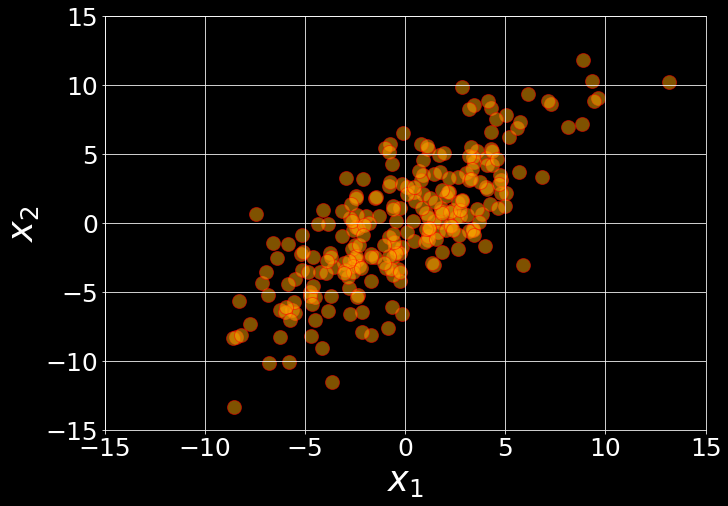

In [ ]:
X =create_elipsoid_data(C1 = 0, C2 = 0, S1 = 6, S2 =2, theta =50, N = 250, random_state = 42) 

fig  = plt.figure(figsize=(10,7))
plt.scatter(X[:, 0],X[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()

plt.xlabel(r'$x_1$',fontsize=35)
plt.ylabel(r'$x_2$',fontsize=35)
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25)
plt.tight_layout()
plt.xlim((-15,15))
plt.ylim((-15,15));

### 1.1.2. Применение метода главных компонент

In [ ]:
class PCA1:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.values = None
        self.mean = None
    
    #--------------------------------    
    def fit(self, X):

        self.mean = np.mean(X, axis=0)
        
        # Считаем матрицу ковариации
        cov_matrix = np.cov(X - self.mean, rowvar = False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

        idx = eigenvalues.argsort()[::-1] #Сортируем по возрастанию
        
        # Берём первые n главных компонент
        self.components = eigenvectors[:, idx][:, :self.n_components]
        self.values     = eigenvalues[idx]
        
        return self
    
    #--------------------------------
    def transform(self, X):
        X = X - self.mean
        return np.dot(X, self.components)
    #--------------------------------
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    #--------------------------------
    def inverse_transform(self, X_new):
        return np.dot(X_new, self.components.T) + self.mean
    #--------------------------------
    def score(self, X):
        SStot = np.sum(np.square(X - np.mean(X)))
        SSres = np.sum(np.square(X - self.inverse_transform(self.fit_transform(X))))
        return 1 - SSres/SStot
    #--------------------------------
    def plot_eigvalues(self, figsize=(15,7)):
        plt.figure(figsize=figsize)
        plt.plot(self.values,'.',
                 label='Все собственные значения',
                 linewidth = 3)
        plt.plot(self.values[:self.n_components],'r-o',
                 label='Собственное Пространство',
                 markersize = 10, mfc='none',
                 linewidth = 2, alpha = 0.8)
        plt.ylabel('собственные\n значения', fontsize=25)
        plt.grid();
        plt.legend(fontsize=25);
        plt.xticks(FontSize = 25); plt.yticks(FontSize = 25);
        plt.tight_layout();    

In [ ]:
pca = PCA1(n_components = 2)

In [ ]:
pca.fit(X)
pca.score(X)

1.0

### 1.1.3. Визуализируем пространство главных компонент

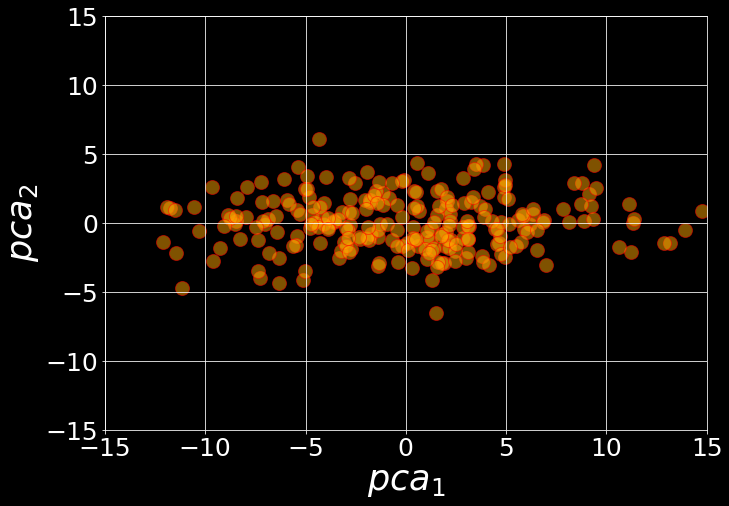

In [ ]:
X_new = pca.transform(X)

fig  = plt.figure(figsize=(10,7))

plt.scatter(X_new[:, 0],X_new[:, 1],
            alpha = 0.5, s = 196,
            c = 'orange', edgecolor = 'r');
plt.grid()
plt.xlabel(r"$pca_1$",fontsize=35)
plt.ylabel(r"$pca_2$",fontsize=35)
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);
plt.tight_layout()
plt.xlim((-15,15))
plt.ylim((-15,15));

In [ ]:
Eigen_Vectors = pca.components
Eigen_Values = pca.values

In [ ]:
print('Собственные векторы:', Eigen_Vectors)

Собственные векторы: [[ 0.64791683 -0.76171109]
 [ 0.76171109  0.64791683]]


In [ ]:
print('Собственные числа: ', Eigen_Values)

Собственные числа:  [33.59868601  3.98326799]


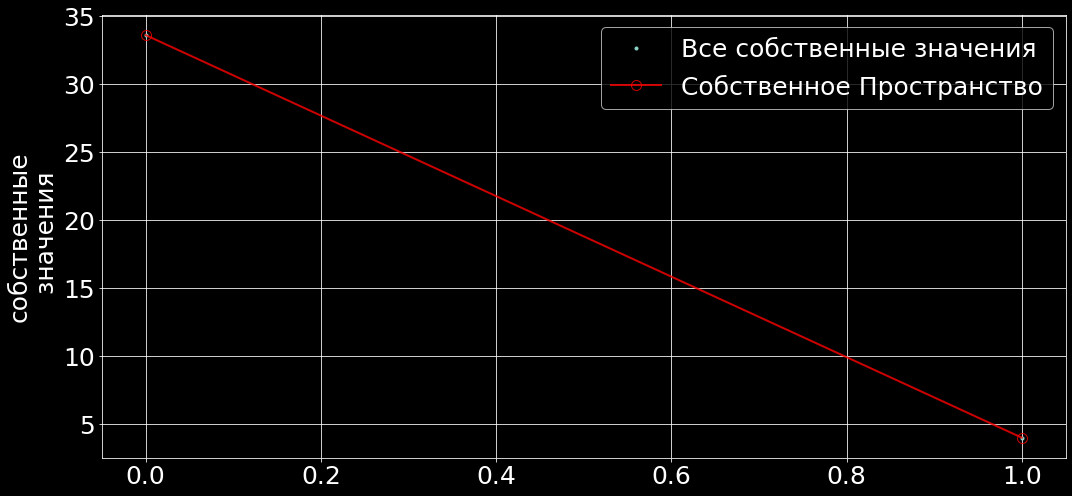

In [ ]:
pca.plot_eigvalues();

Собственные числа показывают каков "разброс" для каждой из компонент, а значит какая доля полезной информации хранится в ней.

In [ ]:
print('Вклад каждой компоненты в "разброс" признаков (в %): ', [i/sum(Eigen_Values)*100 for i in Eigen_Values])

Вклад каждой компоненты в "разброс" признаков (в %):  [89.40111525942334, 10.598884740576658]


In [ ]:
X_mean = np.mean(X, axis = 0)

theta_ = 2 * np.pi * np.arange(0,1,0.01)

X_std = Eigen_Vectors @ np.diag(np.sqrt(Eigen_Values)) @ np.array([np.cos(theta_),np.sin(theta_)])

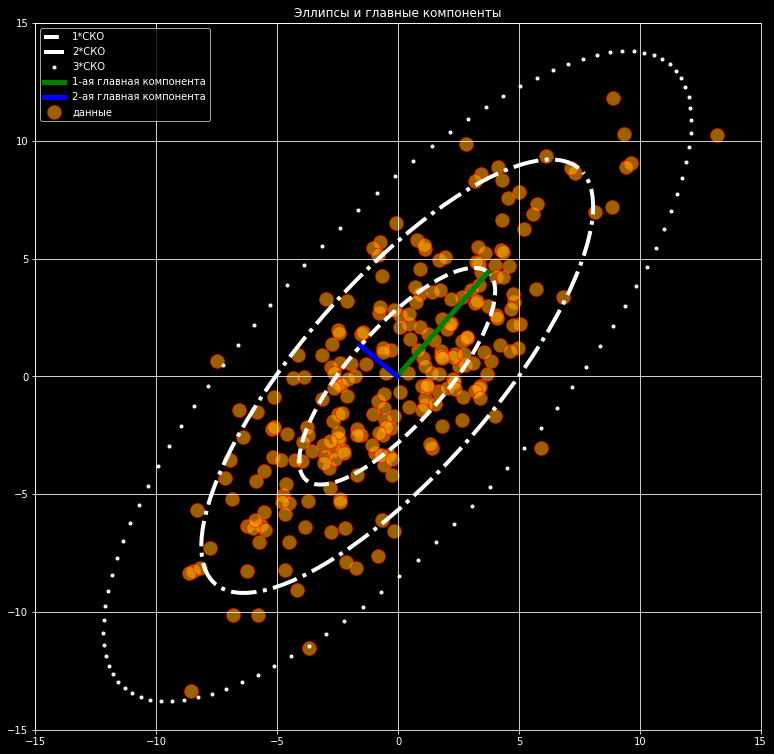

In [ ]:
fig = plt.figure(figsize=(13,13))
# рисуем данные
plt.scatter(X[:,0],X[:,1], alpha = 0.6, label = 'данные',s = 196, c = 'orange', edgecolor = 'r')
# рисуем эллипс с "диаметром" ~ 1*СКО
plt.plot(X_std[0,:]+X_mean[0],X_std[1,:]+X_mean[1], 
         '--', c = 'w', linewidth = 4, label = '1*СКО')
#рисуем эллипс с "диаметром" ~ 2*СКО
plt.plot(2*X_std[0,:]+X_mean[0],2*X_std[1,:]+X_mean[1],
         '-.', c = 'w', linewidth = 4, label = '2*СКО')
#рисуем эллипс с "диаметром" ~ 3*СКО
plt.plot(3*X_std[0,:]+X_mean[0],3*X_std[1,:]+X_mean[1],
         '.', c = 'w', linewidth = 4, label = '3*СКО')
# 1-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,0]*np.sqrt(Eigen_Values[0])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,0]*np.sqrt(Eigen_Values[0])]),
         'g',linewidth = 5, label = '1-ая главная компонента')
# 2-ая главная компонента
plt.plot(np.array([X_mean[0], X_mean[0]+Eigen_Vectors[0,1]*np.sqrt(Eigen_Values[1])]),
         np.array([X_mean[1], X_mean[1]+Eigen_Vectors[1,1]*np.sqrt(Eigen_Values[1])]),
         'b',linewidth = 5, label = '2-ая главная компонента')
plt.xlim((-15,15))
plt.ylim((-15,15))
plt.title('Эллипсы и главные компоненты')
plt.legend()
plt.grid()

In [ ]:
X_new[:, 0],X_new[:, 1]

(array([  3.01190378,  -0.82714003,   3.87229789,   9.13886117,
         -1.36973124,  -1.38353387,   9.47280288,   4.62876135,
         -2.80798969,   3.25963739,  -2.75324218,  -2.77876285,
          1.51002207, -11.4509126 , -10.33112858,  -3.342139  ,
         -6.08401853,   1.91940055,  -5.42735886,  -8.46063364,
          8.78909241,  -1.32059138,   0.40429294,  -8.53368053,
         -3.23828847,   0.67406811,  -6.89372571,   2.27695106,
         -3.58993499,  -1.73019527,  -3.59692945,  11.11927992,
         -0.08752729,  -6.31474625,   4.92126641,  -7.28392835,
          1.26994498, -11.75090306,  -7.95795687,   1.20425648,
          4.44824782,   1.04956045,  -0.67120602,  -1.80323769,
         -8.86097312,  -4.29490932,  -2.761098  ,   6.35321685,
          2.0655004 , -10.57170463,   1.97034608,  -2.28816548,
         -4.05672276,   3.67653146,   6.20089167,   5.60073242,
         -5.03759645,  -1.83253476,   1.99494195,   5.8706074 ,
         -2.85730402,  -1.11393123,  -6.

Преобразование от осей координат данных к лавным осям представляет собой аффинное преобразование и состоит из сдвига, вращения и пропорционального масштабирования

## 1.2. Набор данных MNIST

In [ ]:
X, y  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)
X = X / 255.
X_ = X.values

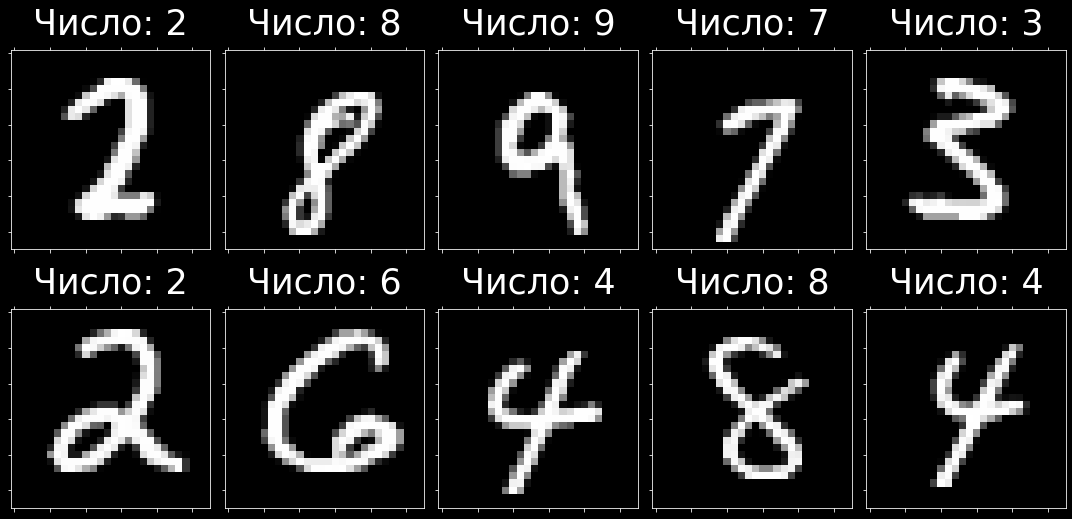

In [ ]:
n = 21722
fig = plt.figure( figsize=(15,8) )
for i in range(0,10):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Число: {}".format(str(y[i+n]) ), size=35)
  ax.matshow(1-X.loc[i+n,'pixel1':'pixel784'].values.reshape((28,28)).astype(float),
             cmap='Greys')
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)
  plt.tight_layout()

###  1.2.1. Метод Главных Компонент (количество компонент - 50)

In [ ]:
pca = PCA1(n_components = 50)
pca.fit(X_)
pca.score(X_)

0.8765399507043385

In [ ]:
pca_result_mnist = pca.transform(X_)
pca_inverse = pca.inverse_transform(pca_result_mnist)
pca_inverse.shape

(70000, 784)

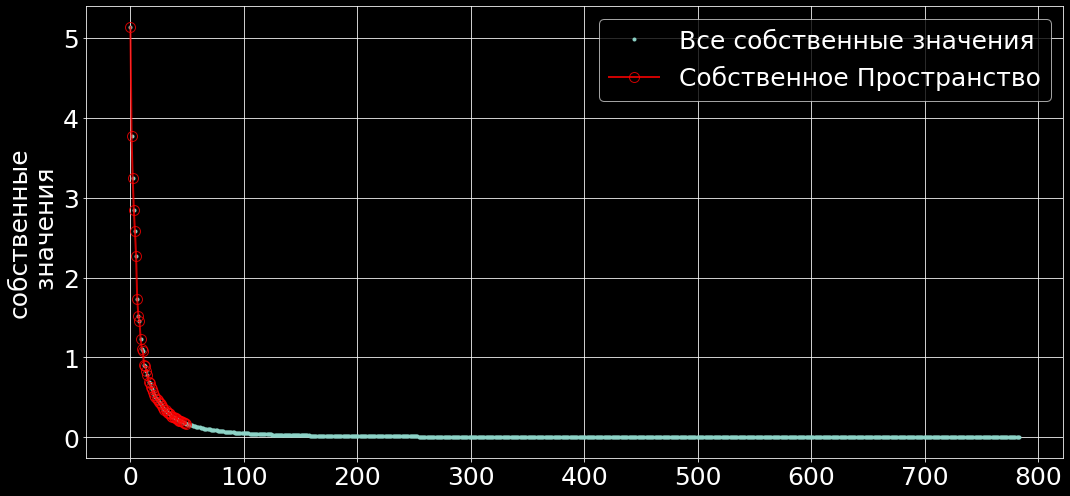

In [ ]:
pca.plot_eigvalues();

In [ ]:
def plot_multi(data, y,  names):
    axis = [[0,1],
            [2,1],
            [0,3],
            [2,3],]


    labels = [['',names[1]],
            ['',''],
            [names[0],names[3]],
            [names[2],'']]

    fig, sub = plt.subplots(2, 2, figsize = (11,11))

    for n, (axi, label, ax) in enumerate(zip(axis,  labels, sub.flatten())):
        scatter = ax.scatter(data[:,axi[0]],data[:,axi[1]],
                             c=y, s = 36, cmap = 'tab10',
                             alpha = 0.7, facecolors = 'none' );
        ax.set_ylabel(label[1], fontsize = 20)
        ax.set_xlabel(label[0], fontsize = 20)
        ax.tick_params(axis='x', labelsize= 15)
        ax.tick_params(axis='y', labelsize= 15)     
        ax.grid()
        ax.set_xlim([-10,12])
        ax.set_ylim([-8,8])
        legend1 = ax.legend(*scatter.legend_elements(),
                        loc="upper right", title="Цифры",
                        fontsize = 15)
        ax.add_artist(legend1)

In [ ]:
pca_names = [str(x+1)+' Главная Компонента' for x in range(4)]

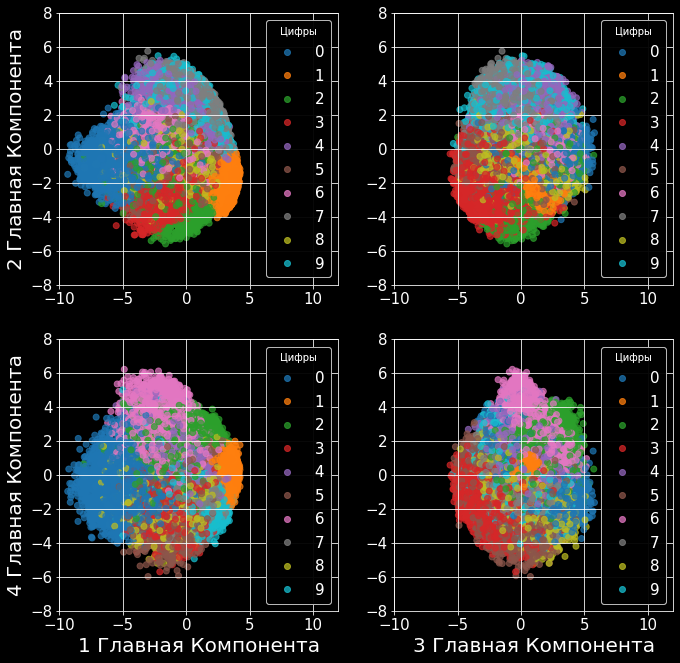

In [ ]:
plot_multi(pca_result_mnist, y.astype(int), pca_names);

Восстановление данных

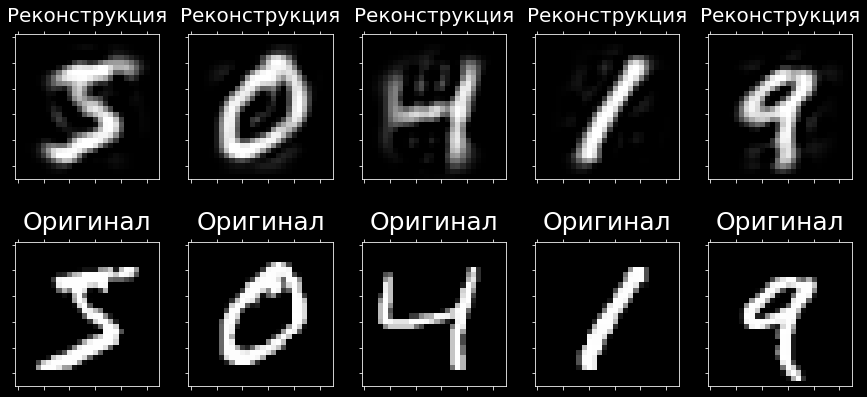

In [ ]:
fig=plt.figure(figsize=(15,7))
for i in range(0,5):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Реконструкция", size=20)  
  ax.matshow(1-pca_inverse[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(2,5,i+6)
  ax.set_title("Оригинал", size=25)    
  ax.matshow(1-X_[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

###  1.2.2. Метод Главных Компонент (количество компонент - 15)

In [ ]:
pca = PCA1(n_components = 15)
pca.fit(X_)
pca.score(X_)

0.7033085671490962

In [ ]:
pca_result_mnist = pca.transform(X_)
pca_inverse = pca.inverse_transform(pca_result_mnist)
pca_inverse.shape

(70000, 784)

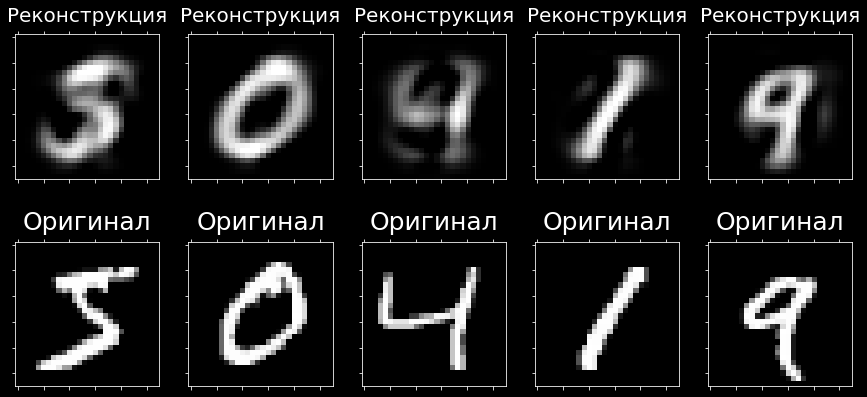

In [ ]:
fig=plt.figure(figsize=(15,7))
for i in range(0,5):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Реконструкция", size=20)  
  ax.matshow(1-pca_inverse[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(2,5,i+6)
  ax.set_title("Оригинал", size=25)    
  ax.matshow(1-X_[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

Вывод: Чем меньшее количество клавных компонент мы используем, тем Реконструкция хуже

###  1.2.3. Определим оптимальное число компонент при заданной точности

In [ ]:
def PCA2(F, varRetained = 0.95, show = False):
    #  Вход
    #  F - исходная матрица 
    # Вычисление сигмы ковариационной матрицы
    # Выход
    (n, l) = F.shape
    Sigma = 1.0 / l * F.dot(np.transpose(F))
    # Compute eigenvectors and eigenvalues of Sigma by SVD
    # U, V - matrix, d - array: Sigma = U * np.diag(d) * V
    #U, d, V = посчитать SVD матрицы Sigma
    U, d, V = np.linalg.svd(Sigma, full_matrices=True)

    # вычислить значение m: количество минимальных признаков, сохраняющих заданную дисперсию varRetaine
    dTot = np.sum(d)
    var_i = np.array([np.sum(d[: i + 1]) / dTot * 100.0 for i in range(n)])
    #m = вычислите необходимое число главных компонент
    m = 0
    while var_i[m] <= varRetained * 100:
        m = m + 1
    print  ("Верните число m и точность, которая достигается при этом числе главных компонент")
    print ('%.2f %% variance retained in %d dimensions' % (var_i[m], m))

    # plot the variance plot
    if show:
        plt.plot(var_i)
        plt.xlabel('Количество функций')
        plt.ylabel(' Percentage Variance retained')
        plt.title('PCA $\% \sigma^2 $ vs # features')
        plt.show()

    # compute the reduced dimensional features by projection
    #U_reduced = только m главных компонент
    U_reduced = U[:, : m + 1]
    #G = вычислить матрицу в преобразованном пространстве
    G = U_reduced.dot(np.diag(d[:m + 1]))

    return G, U_reduced

Performing PCA - Principal COmponent Analysis
Верните число m и точность, которая достигается при этом числе главных компонент
95.02 % variance retained in 101 dimensions


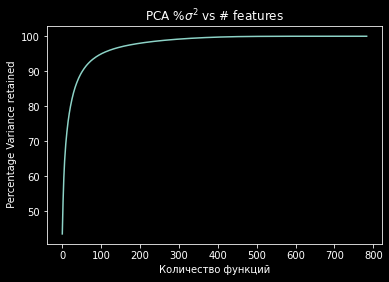

In [ ]:
print ('Performing PCA - Principal COmponent Analysis')

Z, U_reduced = PCA2(X_.T, varRetained = 0.95, show = True)

Проверим на 101 компонентках

In [ ]:
pca = PCA1(n_components = 101)
pca.fit(X_)
pca.score(X_)

0.9405569377388024

In [ ]:
pca_result_mnist = pca.transform(X_)
pca_inverse = pca.inverse_transform(pca_result_mnist)
pca_inverse.shape

(70000, 784)

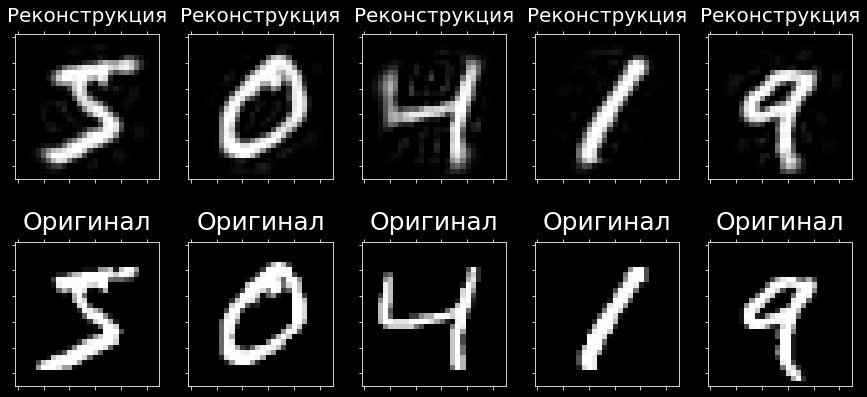

In [ ]:
fig=plt.figure(figsize=(15,7))
for i in range(0,5):
  ax = fig.add_subplot(2,5,i+1)
  ax.set_title("Реконструкция", size=20)  
  ax.matshow(1-pca_inverse[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

for i in range(0,5):
  ax = fig.add_subplot(2,5,i+6)
  ax.set_title("Оригинал", size=25)    
  ax.matshow(1-X_[i,:].reshape((28,28)).astype(float),cmap='Greys', vmin = 0, vmax = 1)
  plt.setp(ax.get_xticklabels(), visible=False)
  plt.setp(ax.get_yticklabels(), visible=False)

При 101  компонентах результат значительно лучше

###  1.2.4. В пространстве главных компонент для данных MNIST определите, каким цифрам соответствуют точки со следующими координатами:

PCA-1 -7; PCA-2 0 - цифра 0  

PCA-1 4; PCA-4 1 - цифра 2

PCA-3 0; PCA-4 5 -  цифра 6

PCA-3 -4; PCA-2 -3 - цифра 3

## 1.3. Набор данных Cars Moldova

In [ ]:
df = pd.read_csv("cars_moldova_categor.csv") #очищенных от дубликатов и выбросов, с добавленными признаками из «Задания 1»
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_q,Make_val,Price_mean_make
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0,11,17727.272727,high_mileage,3091,9629.435781
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0,8,16875.000000,average_mileage,2371,6624.550822
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0,10,11000.000000,little_mileage,2371,6624.550822
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0,16,12500.000000,average_mileage,1867,4169.550080
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0,22,13636.363636,average_mileage,3032,12960.053100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0,6,14666.666667,average_mileage,3450,6839.976522
32470,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0,20,11250.000000,little_mileage,288,22631.614583
32471,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0,7,12714.285714,average_mileage,1348,5327.074926
32472,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0,16,23125.000000,high_mileage,444,5145.808559


In [ ]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission',"km_year_q"]
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', "Age", 'km_year', "Make_val", "Price_mean_make"] 

In [ ]:
df[cat_columns] = df[cat_columns].astype('category')

for _, column_name in enumerate(cat_columns):
    df[column_name] =  df[column_name].cat.codes
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_q,Make_val,Price_mean_make
0,41,541,2011,4,195000.0,1800.0,2,0,7750.0,11,17727.272727,1,3091,9629.435781
1,33,364,2014,11,135000.0,1500.0,0,1,8550.0,8,16875.000000,0,2371,6624.550822
2,33,425,2012,11,110000.0,1500.0,0,1,6550.0,10,11000.000000,2,2371,6624.550822
3,28,139,2006,11,200000.0,1600.0,3,1,4100.0,16,12500.000000,0,1867,4169.550080
4,23,731,2000,5,300000.0,2200.0,0,1,3490.0,22,13636.363636,0,3032,12960.053100


In [ ]:
from sklearn.decomposition import PCA

### 1.3.1. Визуализация пространства главных компонент и их связь с исходными признаками

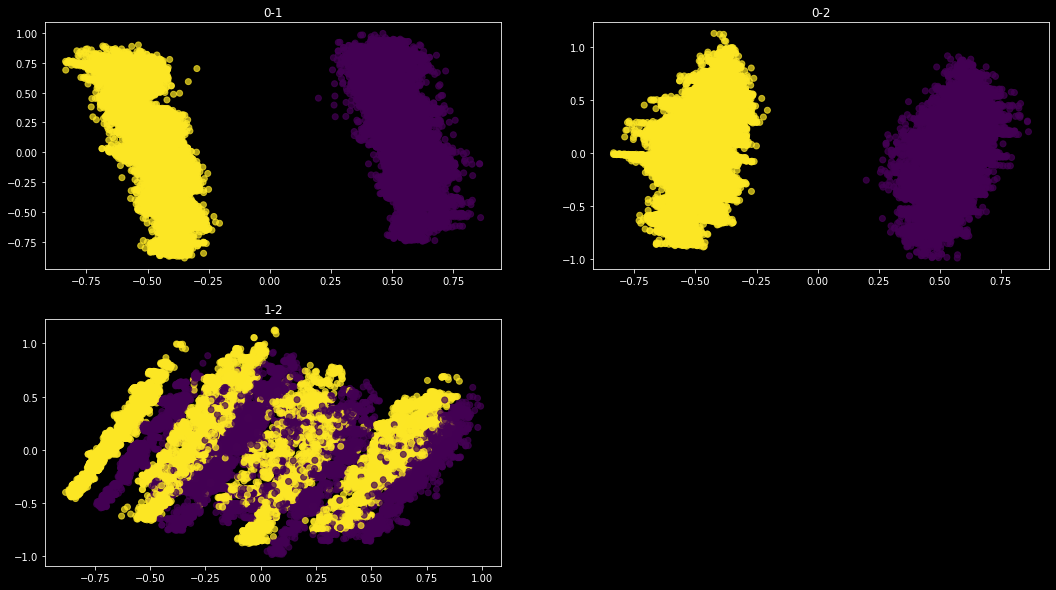

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
pca = PCA()
labels = df.Transmission

X_new = pca.fit_transform(X)
X_new.shape

plt.figure(figsize=(18,10))
plt.subplot(221); plt.scatter(X_new[:,0],X_new[:,1], c =labels, alpha = 0.7); plt.title("0-1")
plt.subplot(222); plt.scatter(X_new[:,0],X_new[:,2], c =labels, alpha = 0.7); plt.title("0-2")
plt.subplot(223); plt.scatter(X_new[:,1],X_new[:,2], c =labels, alpha = 0.7); plt.title("1-2")
plt.show();

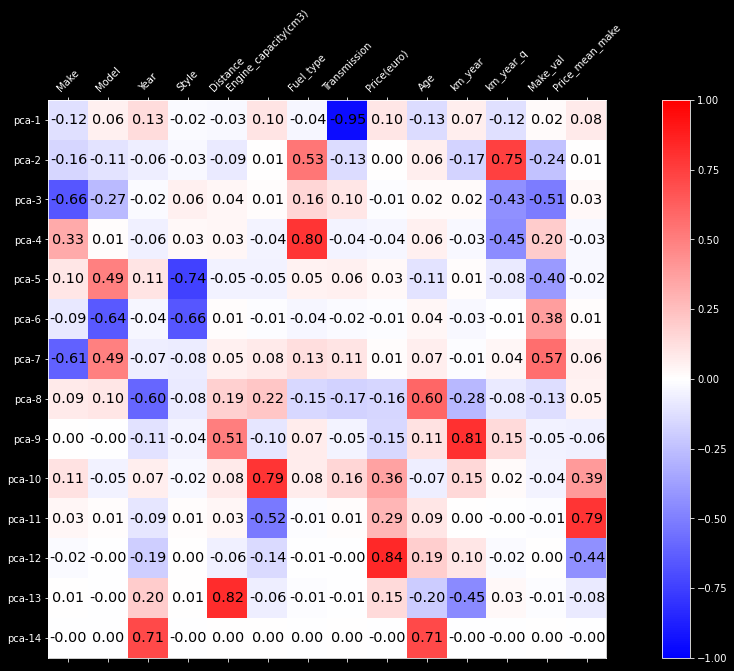

In [ ]:
fig=plt.figure(figsize=(20,10))
W = pca.components_
pca_names = ['pca-'+str(x+1) for x in range(W.shape[0])]
plt.matshow(W.astype(float),cmap='bwr',vmin=-1,vmax=1, fignum=1)
for (i, j), z in np.ndenumerate(W):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color = 'k', fontsize = 'x-large')
plt.xticks(np.arange(0, W.shape[1]), df.columns,rotation = 45)
plt.yticks(np.arange(0, W.shape[0]),pca_names)
plt.colorbar();

### 1.3.2.  Применение пространства главных компонент в качестве входных данных для алгоритмов классификации

In [ ]:
X = df.drop(('Style'), axis = 1) # выбрасываем столбец 'Style'
y = df['Style']
feature_names = X.columns

In [ ]:
print(X.shape)
print(y.shape)
N, d = X.shape

(32474, 13)
(32474,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 
print(N_train, N_test)

25979 6495


In [ ]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

In [ ]:
print(pca.components_)
print(pca.explained_variance_)
print(pca.singular_values_)

[[-4.63055353e-07 -8.39278546e-05 -3.01057026e-05  9.98811513e-01
   4.55494544e-04 -2.62412999e-06  9.35240927e-07 -3.24468842e-02
   3.01057026e-05  3.63242399e-02 -2.98731338e-06  1.75881671e-03
  -1.67815108e-05]
 [-1.90343714e-04  2.78332857e-03  4.24063461e-04  1.41519304e-02
   2.44373742e-02 -4.08804775e-05 -2.50190465e-05  8.86780680e-01
  -4.24063461e-04  4.02467704e-01 -1.50660254e-05  6.67229679e-03
   2.25365583e-01]]
[9.54641466e+09 9.34902583e+07]
[15747912.87623087  1558425.46473624]


In [ ]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
knn = KNeighborsClassifier(n_neighbors = 10, metric='hamming', n_jobs = 4)
knn.fit(X_train_pca, y_train)
y_train_predict_pca = knn.predict(X_train_pca)
y_test_predict_pca = knn.predict(X_test_pca)
err_train_pca = np.mean(y_train != y_train_predict_pca)
err_test_pca  = np.mean(y_test  != y_test_predict_pca)
print(err_train_pca)
print(err_test_pca)

0.6950229031140537
0.7006928406466513


# 2. Кластеризация К-средних

## 2.1.  Для синтетических данных

In [ ]:
def plot_data(ax,ds,name='',marker = 'o',colors =("#FF0000", '#0000FF'),alpha=0.7, s = 150, facecolor=True):
    X, y = ds

    cm_bright = ListedColormap(colors)
    ax.set_title(name, fontsize = 30)
    if facecolor:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   alpha =alpha)
    else:
        ax.scatter(X[:, 0], X[:, 1],
                   marker = marker, c=y,
                   cmap=cm_bright,s = s,
                   facecolor = 'None',
                   alpha =alpha)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    ax.grid(True)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

In [ ]:
class KMeans():
    def __init__(self,n_clusters = 2, centroids = None,
                 max_iter=10, tol=0.01,
                 metric = 'euclidean', p = 2,
                 random_state = None):
        self.n_clusters = n_clusters
        self.centroids  = centroids
        self.max_iter   = max_iter        
        self.tol        = tol
        self.iters      = None
        self.inertia = None
        self.metric = metric
        self.p  = p
        self.random_state  = random_state
    #-------------------------------------    
    def distance(self,X1, X2):
        if self.metric == 'euclidean':
            dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
        if self.metric == 'cityblock':
            dist = np.sum(np.abs(X1 - X2).T,axis=0)
        if self.metric == 'Chebyshev':
            dist = np.max(np.abs(X1 - X2).T,axis=0)  
        if self.metric == 'Minkowski':
            dist = np.power(np.sum(np.power(np.abs(X1 - X2),self.p).T,axis=0),1/self.p)      
        return dist
    #-------------------------------------
    def init_centroids(self, X):
        if self.random_state: rng = np.random.seed(self.random_state)
        c_idxs = np.random.randint(0, X.shape[0], size = self.n_clusters)
        return X[c_idxs,:]
    #-------------------------------------
    def predict(self, X):
        distances = np.zeros((X.shape[0], self.n_clusters))

        for i,centr in enumerate(self.centroids):
            distances[:,i] = self.distance(centr,X)
        self.inertia = np.sum(np.power(np.min(distances,axis = 1),2))
        return np.argmin(distances,axis = 1) 
    #-------------------------------------
    def transform(self,X):
        return self.predict(X)
    #-------------------------------------
    def delta_centroids(self,old_centroids):
        return (
                distance(self.centroids,old_centroids)/
                distance(old_centroids, np.mean(old_centroids))
               ).mean()
    #-------------------------------------
    def fit(self, X):
        
        if self.centroids is None:
            self.centroids = self.init_centroids(X)
    
        d_centrs = np.inf

        for i in range(self.max_iter):

            old_centroids = np.copy(self.centroids)
            
            cluster_label = self.predict(X)

            for k in range(self.n_clusters):
                
                c_idxs = np.flatnonzero(cluster_label==k)
                
                self.centroids[k] = X[c_idxs].mean(axis = 0)

            d_centrs = self.delta_centroids(old_centroids)

            self.iters = i
            if d_centrs<=self.tol:
                break
        return self        
    #-------------------------------------
    def fit_transform(self, X):
        return self.fit(X).predict(X)

In [ ]:
def plot_cluster(X,centroids, cluster_label, centroids_label, old_centroids = None, old_centroids_label = None):
    
    fig = plt.figure(figsize=(11,10))

    plt.scatter(X[:, 0], X[:, 1], 
                c = cluster_label, cmap = 'bwr',
                s=100,alpha = 0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                c = centroids_label, cmap = 'bwr',
                s=400, edgecolors = 'k')
    
    if old_centroids is not None:
        plt.scatter(old_centroids[:, 0], old_centroids[:, 1],
            c = old_centroids_label, cmap = 'bwr',
            s=200, edgecolors = 'k')  

    plt.xticks([])
    plt.yticks([])

### 2.1.1  Генерация данных - Инь-Ян

In [ ]:
X_mon, y_mon = make_moons(n_samples=400, noise=0.20, random_state=42)

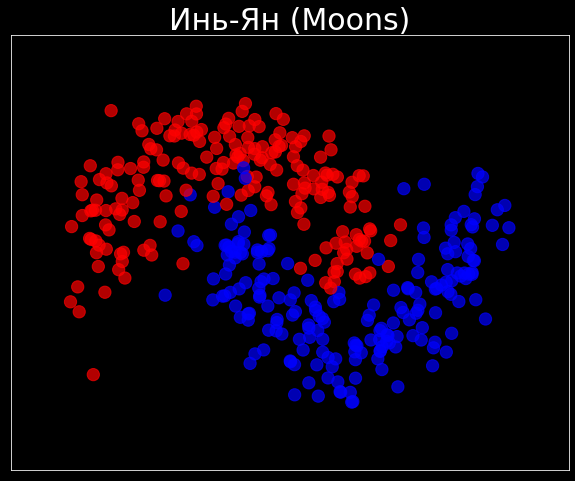

In [ ]:
fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X_mon, y_mon), 'Инь-Ян (Moons)')

In [ ]:
def distance(X1, X2, metric = 'euclidean', p = 2):
    if metric == 'euclidean':
        dist = np.sqrt(np.sum(np.square(X1 - X2).T,axis=0))
    if metric == 'cityblock':
        dist = np.sum(np.abs(X1 - X2).T,axis=0)
    if metric == 'Chebyshev':
        dist = np.max(np.abs(X1 - X2).T,axis=0)  
    if metric == 'Minkowski':
        dist = np.power(np.sum(np.power(np.abs(X1 - X2),p).T,axis=0),1/p)      
    return dist

Оценка оптимального числа кластеров по методу Локтя

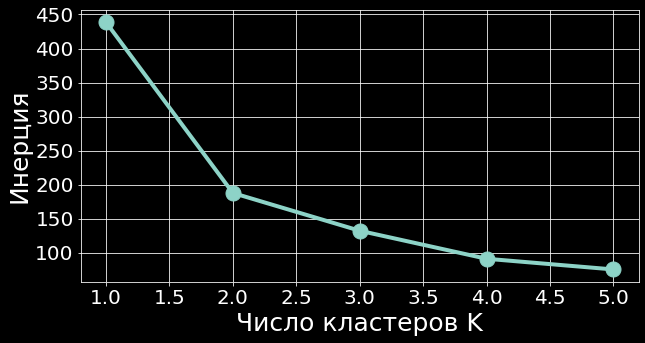

In [ ]:
sse = []
list_k = list(range(1, 6))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_mon)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

Посмотрим для 2 кластеров

Мы остановились на итерации:: 5


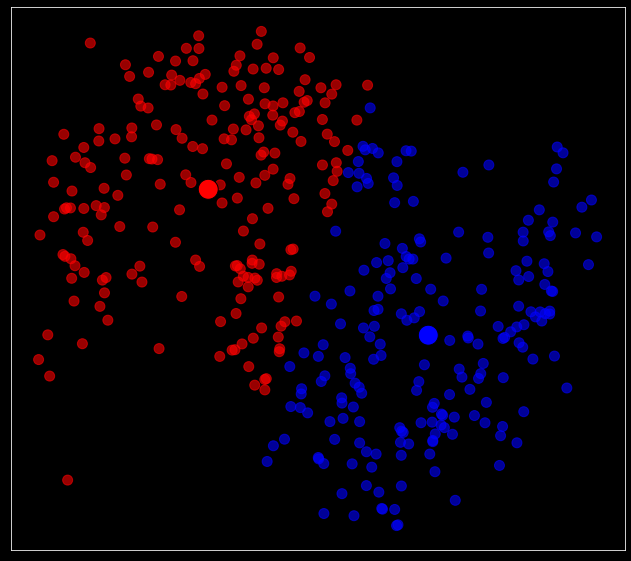

In [ ]:
kmeans   = KMeans(n_clusters=2,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_mon)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X_mon,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

Посмотрим для 4 кластеров

Мы остановились на итерации:: 7


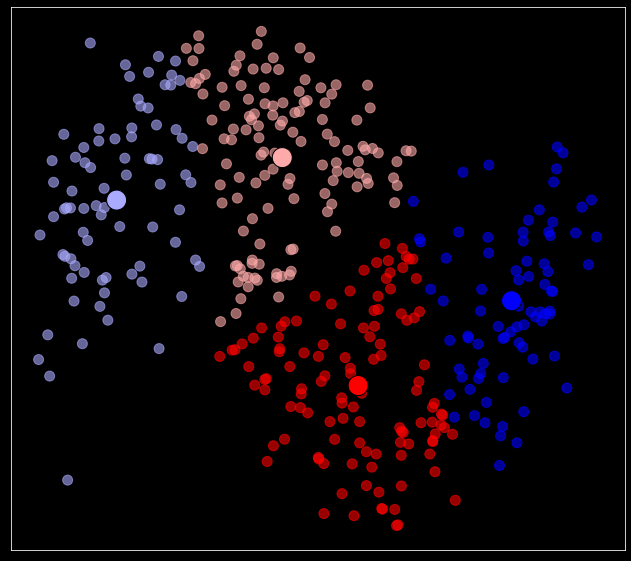

In [ ]:
kmeans   = KMeans(n_clusters=4,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_mon)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X_mon,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

In [ ]:
pd.crosstab(y_mon,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2,3
Метки,,,,
0,6,74,95,25
1,72,5,31,92


### 2.1.2 Генерация данных - Круги

In [ ]:
X_k, y_k = make_circles(n_samples=400, noise=0.09, random_state=42)

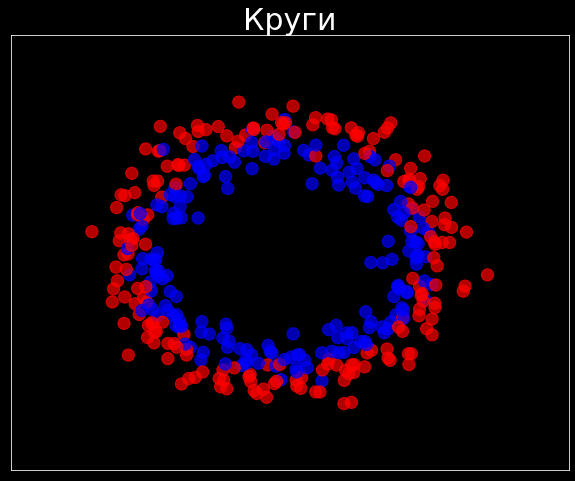

In [ ]:
fig = plt.figure(figsize= (10,8))
ax = plt.subplot(1, 1, 1)
plot_data(ax,(X_k, y_k), 'Круги')

Оценка оптимального числа кластеров по методу Локтя

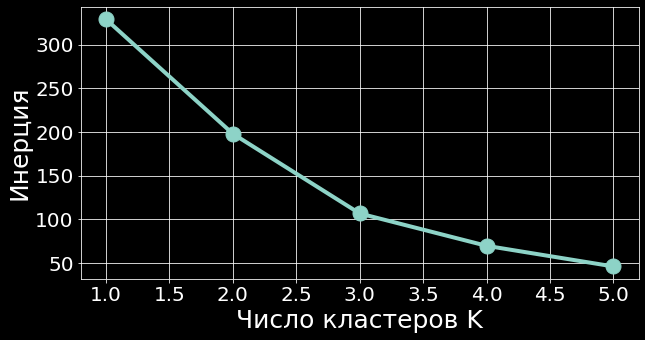

In [ ]:
sse = []
list_k = list(range(1, 6))
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_k)
    sse.append(km.inertia)

plt.figure(figsize=(10, 5))
plt.plot(list_k, sse, '-o',
         linewidth = 4, markersize = 15)
plt.xlabel('Число кластеров K', fontsize = 25)
plt.ylabel('Инерция', fontsize = 25)

plt.grid();
plt.xticks(FontSize = 20)
plt.yticks(FontSize = 20);

Посмотрим для 3 кластеров

Мы остановились на итерации:: 4


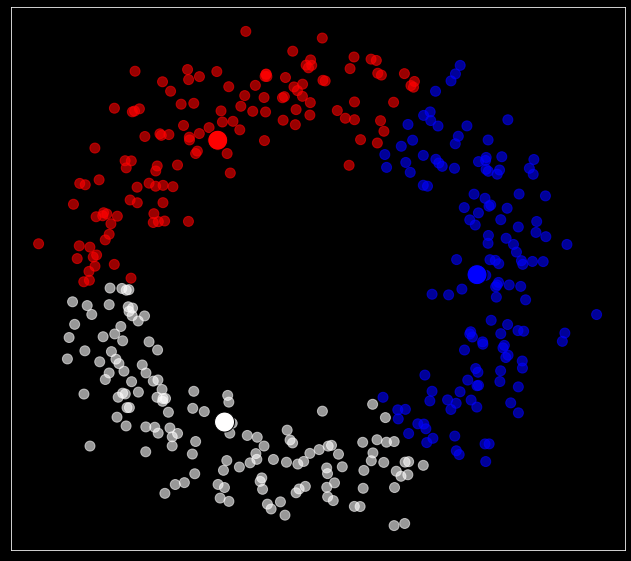

In [ ]:
kmeans   = KMeans(n_clusters=3,max_iter=100, tol=0.01, random_state= 42)
c_labels = kmeans.fit_transform(X_k)

print('Мы остановились на итерации::',kmeans.iters)


plot_cluster(X_k,kmeans.centroids, 
             c_labels, np.unique(c_labels),)

In [ ]:
pd.crosstab(y_k,c_labels, rownames=['Метки'], colnames = ['Предсказания'])

Предсказания,0,1,2
Метки,,,
0,64,69,67
1,70,70,60


## 2.2. Для набора данных MNIST

In [ ]:
X_m, y_m  = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame = True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_m, y_m, test_size=0.2, random_state=12)

In [ ]:
knn=KNeighborsClassifier(n_neighbors=7)

In [ ]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=7)

In [ ]:
y_pred = knn.predict(X_test)
y_pred

array(['3', '7', '1', ..., '5', '7', '2'], dtype=object)

In [ ]:
report  = classification_report(y_test, y_pred)

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1358
           1       0.96      0.99      0.98      1596
           2       0.99      0.96      0.97      1403
           3       0.97      0.98      0.97      1450
           4       0.98      0.96      0.97      1327
           5       0.96      0.97      0.96      1249
           6       0.98      0.99      0.98      1367
           7       0.97      0.97      0.97      1459
           8       0.99      0.93      0.96      1413
           9       0.95      0.96      0.96      1378

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



<Figure size 720x576 with 0 Axes>

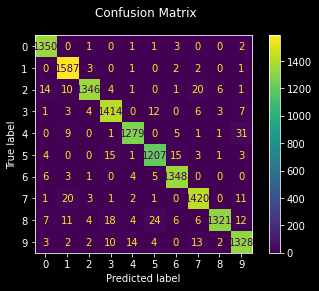

In [ ]:
fig = plt.figure(figsize= (10,8))
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.figure_.suptitle("Confusion Matrix")

plt.show()

In [ ]:
acc = knn.score(X_test, y_test)
print("accuracy from knn.score = ", acc)

accuracy from knn.score =  0.9714285714285714


## 2.3. Для набора данных Cars Moldova

In [ ]:
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_q,Make_val,Price_mean_make
0,41,541,2011,4,195000.0,1800.0,2,0,7750.0,11,17727.272727,1,3091,9629.435781
1,33,364,2014,11,135000.0,1500.0,0,1,8550.0,8,16875.000000,0,2371,6624.550822
2,33,425,2012,11,110000.0,1500.0,0,1,6550.0,10,11000.000000,2,2371,6624.550822
3,28,139,2006,11,200000.0,1600.0,3,1,4100.0,16,12500.000000,0,1867,4169.550080
4,23,731,2000,5,300000.0,2200.0,0,1,3490.0,22,13636.363636,0,3032,12960.053100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,43,517,2016,10,88000.0,1800.0,4,0,11500.0,6,14666.666667,0,3450,6839.976522
32470,19,328,2002,3,225000.0,1800.0,3,1,4400.0,20,11250.000000,2,288,22631.614583
32471,6,439,2015,11,89000.0,1500.0,0,1,7000.0,7,12714.285714,0,1348,5327.074926
32472,22,78,2006,1,370000.0,2000.0,0,1,4000.0,16,23125.000000,1,444,5145.808559


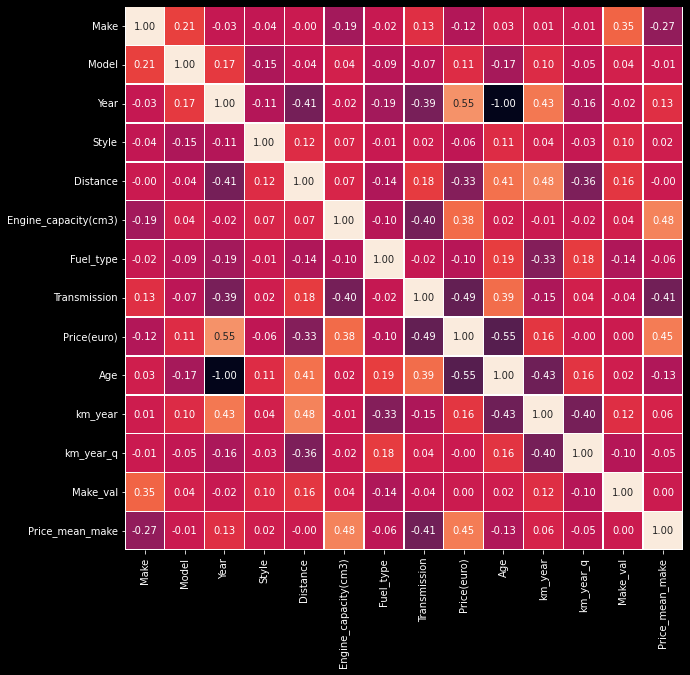

In [ ]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

In [ ]:
df['Transmission'].unique()

array([0, 1], dtype=int8)

In [ ]:
y = df['Transmission']

In [ ]:
x= df.drop(columns = 'Transmission')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((25979, 13), (6495, 13), (25979,), (6495,))

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
wcss = []
x = X.to_numpy()

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(x) #Вычислить кластеризацию k-средних.
    wcss.append(kmeans.inertia_)

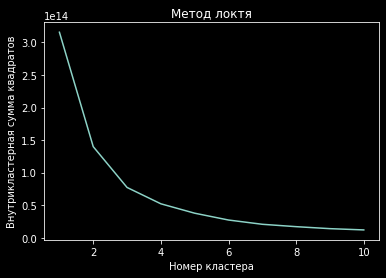

In [ ]:
plt.plot(range(1, 11), wcss)
plt.title('Метод локтя')
plt.xlabel('Номер кластера')
plt.ylabel('Внутрикластерная сумма квадратов') 
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 6, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit(x)
labels1 = kmeans.labels_
centroids1 = kmeans.cluster_centers_
Z = y_kmeans.predict(x)
df['Номер кластера'] = Z
df.head()

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,km_year_q,Make_val,Price_mean_make,Номер кластера
0,41,541,2011,4,195000.0,1800.0,2,0,7750.0,11,17727.272727,1,3091,9629.435781,4
1,33,364,2014,11,135000.0,1500.0,0,1,8550.0,8,16875.000000,0,2371,6624.550822,0
2,33,425,2012,11,110000.0,1500.0,0,1,6550.0,10,11000.000000,2,2371,6624.550822,0
3,28,139,2006,11,200000.0,1600.0,3,1,4100.0,16,12500.000000,0,1867,4169.550080,4
4,23,731,2000,5,300000.0,2200.0,0,1,3490.0,22,13636.363636,0,3032,12960.053100,1


In [ ]:
df.groupby('Номер кластера')\
  .agg(Размерность_кластера = ('Номер кластера', 'count'))\
  .reset_index()\
  .sort_values(by = 'Размерность_кластера', ascending=False)

,Номер кластера,Размерность_кластера
4,4,10829
0,0,8588
1,1,6363
2,2,4958
3,3,1684
5,5,52


In [ ]:
rating_cluster = df.groupby('Номер кластера').mean().reset_index().sort_values(by = 'Transmission', ascending = False)
rating_cluster.T

,5,3,1,4,0,2
Номер кластера,5.000000,3.000000,1.000000,4.000000,0.000000,2.000000
Make,27.076923,21.852138,23.839855,26.078401,24.247904,23.151069
Model,285.423077,351.932304,361.307402,388.154216,393.444923,376.579064
Year,1993.788462,2000.314133,2003.753733,2008.798689,2010.945040,2010.811416
Style,8.153846,8.540380,8.129342,7.544372,7.122380,7.231747
Distance,868371.153846,394435.588480,276225.586673,196301.986333,128369.274220,37460.347519
Engine_capacity(cm3),1776.500000,2048.208432,1975.181675,1804.049958,1818.978458,1889.261396
Fuel_type,2.826923,1.736342,1.640578,1.643550,2.031905,2.584712
Transmission,0.903846,0.728029,0.650322,0.584080,0.466348,0.400565
Price(euro),3723.461538,4346.875891,5681.632720,8177.532459,11017.427340,15898.443526
